# Práctica 3
## Juan José Herrera Aranda

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/.shortcut-targets-by-id/1f4_bhvRaJhUMnZZ4MeBoNGoM9eWVOzBa/Colab Notebooks


In [3]:
ls

'Copia de Ejercicio_3.ipynb'    model.png
'Copia de Untitled0.ipynb'      test_images.npy
 Ejercicio_3.ipynb              test_labels.npy
 images/                        train_images.npy
 images.tgz                     train_labels.npy
 lists.tgz                      trash/
'lists.tgz (Unzipped Files)'/   Untitled0.ipynb
 model_plot.png                'Vision por Computador'/


In [4]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from math import ceil
from random import shuffle,seed
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.datasets import cifar100
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Activation, UpSampling2D, add
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations

from sklearn.model_selection import StratifiedKFold

from keras.applications.resnet import ResNet50, preprocess_input

from keras.preprocessing.image import load_img,img_to_array

seed(123456)

# Funciones Auxiliares

In [5]:
#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función solo se la llama una vez. Devuelve 4 
# vectores conteniendo, por este orden, las imágenes
# de entrenamiento, las clases de las imágenes de
# entrenamiento, las imágenes del conjunto de test y
# las clases del conjunto de test.

def cargarImagenes(visualizeFlag=False):
    # Cargamos Cifar100. Cada imagen tiene tamaño
    # (32 , 32, 3). Nos vamos a quedar con las
    # imágenes de 25 de las clases.
    (x_train, y_train), (x_test, y_test) = cifar100.load_data (label_mode ='fine')

    # summarize loaded dataset
    print('Summary original dataset: ')
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape (train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]

    # Transformamos los vectores de clases en matrices.
    # Cada componente se convierte en un vector de ceros
    # con un uno en la componente correspondiente a la
    # clase a la que pertenece la imagen. Este paso es
    # necesario para la clasificación multiclase en keras.
    y_train = keras.utils.np_utils.to_categorical(y_train, 25)
    y_test = keras.utils.np_utils.to_categorical(y_test, 25)

    if visualizeFlag:
      number_images_per_row = 3
      result = np.where(y_train == 1)
      fig = pyplot.figure()
      for i in range(number_images_per_row*number_images_per_row):
        # define subplot
        label = 'Class {}'.format(result[1][i])
        pyplot.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
        # plot raw pixel data
        pyplot.imshow(x_train[i])
      # show the figure
      fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
      pyplot.show()

    # summarize loaded dataset
    print('Summary reduced dataset: ')
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    
    return x_train , y_train , x_test , y_test

#########################################################################
######## FUNCIÓN PARA MOSTRAR LA EVOLUCIÓN DEL MODELO ###################
#########################################################################

# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelven las
# funciones fit() y fit_generator()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    pyplot.plot(loss)
    pyplot.plot(val_loss)
    pyplot.legend(['Training loss', 'Validation loss'])
    pyplot.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    pyplot.plot(acc)
    pyplot.plot(val_acc)
    pyplot.legend(['Training accuracy','Validation accuracy'])
    pyplot.show()



#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes, clases




#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path):
  # Cargamos los ficheros
  train_images = np.loadtxt(path + "/train.txt", dtype = str)
  test_images = np.loadtxt(path + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images,path)
  test, test_clases = leerImagenes(test_images,path)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]
  
  return train, train_clases, test, test_clases


#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


#########################################################################
############# FUNCIÓN AUXILIARES PRACTICA ANTERIORES ####################
#########################################################################


def normalizar_mat(im):
  minimo = min(im.ravel())
  maximo = max(im.ravel())
  rango = maximo-minimo
  return (im-minimo)/rango

def pintaI(im, figsize=(5,5)):
  im_norm = normalizar_mat(im)
  cmap = 'gray' if len(im.shape) == 2 else None
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow( im_norm, cmap=cmap, vmin=0.0, vmax=1.0 )
  plt.show(block=False)

def pintaMIE(vim, titulos, ncol = 2, figsize=(12,12)):
  fig = plt.figure(figsize=figsize)
  #fig = plt.figure()
  for k, im in enumerate(vim):
    sub = fig.add_subplot( ceil(len(vim)/ncol), ncol, k + 1 )
    plt.axis('off')
    plt.title(titulos[k])
    cmap = 'gray' if len(im.shape) == 2 else None
    sub.imshow(normalizar_mat(im), cmap=cmap)
  plt.show(block=False)

Cargamos las imágenes y establecemos algunas variables globales necesarias

In [6]:
# TAMAÑO DE BATCH
batch_size = 64   
# NÚMERO DE CLASES
num_classes = 25
# ÉPOCAS DE ENTRENAMIENTO
epochs = 30

# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 32, 32

x_train, y_train, x_test, y_test = cargarImagenes()

if K.image_data_format() == 'channels_first': #[canales,filas,columnas]
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols) #Tiene un canal porque son en blanco y negro
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else: #[filas,columnas,canales]
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)



# Como tenemos las clases ordenadas, lo que haremos será desordenarlas
ind_train = list(range(len(x_train)))
ind_test = list(range(len(x_test)))
shuffle(ind_train)
shuffle(ind_test)
    
x_train = x_train[ind_train]
y_train = y_train[ind_train]
x_test  = x_test[ind_test]
y_test  = y_test[ind_test]

v_xy_train_test = [x_train,y_train,x_test,y_test]

169017344/169001437 [==============================] - 11s 0us/step
Summary original dataset: 
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Summary reduced dataset: 
Train: X=(12500, 32, 32, 3), y=(12500, 25)
Test: X=(2500, 32, 32, 3), y=(2500, 25)


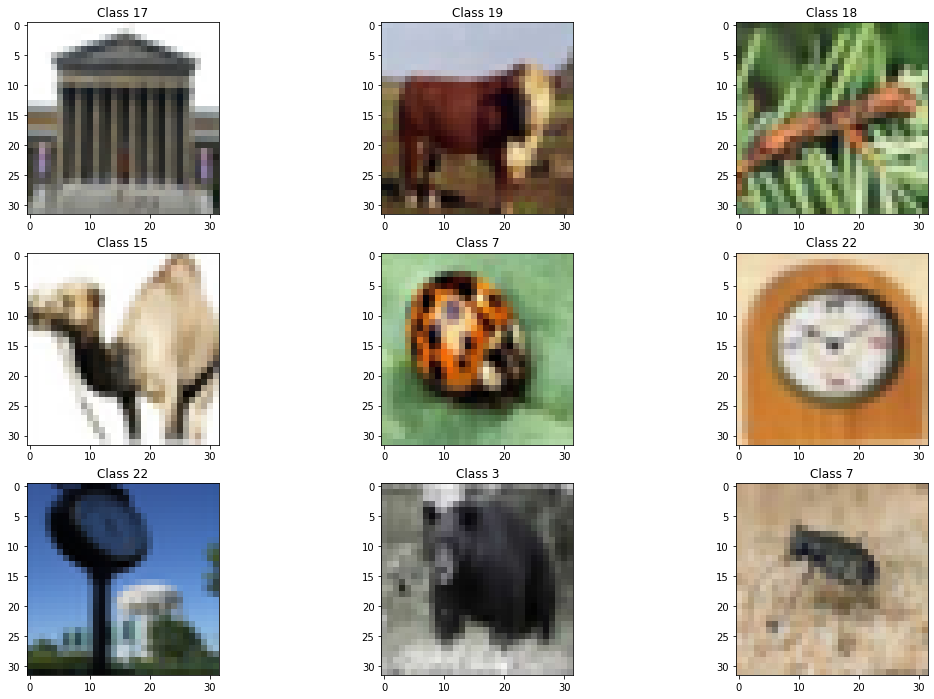

In [ ]:
#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = pyplot.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  pyplot.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  pyplot.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
pyplot.show()

# Ejercicio 1

Declaramos el modelo de BaseNet

In [ ]:
def BaseNet():
  model = Sequential()
  model.add(Conv2D(filters=6,kernel_size=(5,5),activation='relu',input_shape=input_shape,name='Conv2D_1'))
  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_1'))
  model.add(Conv2D(filters=16,kernel_size=(5,5),activation='relu',name='Conv2D_2'))
  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_2'))
  model.add(Flatten(name='Flatten'))
  model.add(Dense(units=50,activation='relu',name='Dense_1'))
  model.add(Dense(units=25,activation='softmax',name='Dense_2'))

  return model


Definimos la función para entrenar y evaluar al modelo con los dataset que se le pasen por parámetro y una función para hacer el procedimiento experimental cross-validation.

In [ ]:
def fit_evaluate(model,opt,batch_size,epochs,v_xy_train_test,verbose=0,show = False,validation_split=None):
  """
  Función que entrena al modelo pasado como parámetro y lo evalua
  """

  x_train = v_xy_train_test[0]
  y_train = v_xy_train_test[1]
  x_test  = v_xy_train_test[2]
  y_test  = v_xy_train_test[3]

  # Configuramos el modelo con la funcion de perdida, optimizador y metrica
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,
                metrics=['accuracy'])
  
  # Entrenamos al modelo
  hist = model.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_split=validation_split)

  # Evaluamos el modelo
  score = model.evaluate(x_test, y_test, verbose=verbose)

  if show == True:
    mostrarEvolucion(hist)

  return score


def cross_val(model,opt,batch_size,epochs,v_xy_train_test,show=False,validation_split=None,verbose=0):
  """
  Función que dado un modelo y algunos parámetros realiza un cross validation y devuelve la media de la precisión
  """
  # Totamos los ejemplos de entrenamiento, no tocamos los de test
  x_train = v_xy_train_test[0]
  y_train = v_xy_train_test[1]

  
  weights       = model.get_weights()    # Guardamos los pesos    
  mean          = 0                      # Media 

  # Inicializamos stratified-cross-validation
  skf = StratifiedKFold(n_splits = 5, shuffle = False) 
  
  # Para cada fold
  for train_index, test_index in skf.split(x_train,y_train.argmax(1)):

    # Calculo los conjuntos de entrenamiento y validacion
    X_train_cross, X_test_cross = x_train[train_index], x_train[test_index]
    Y_train_cross, y_test_cross = y_train[train_index], y_train[test_index]

    # Entrenamos y evaluamos el modelo con los datos de entrenamiento y validación
    v_skf = [X_train_cross,Y_train_cross,X_test_cross,y_test_cross]
    score = fit_evaluate(model,opt,batch_size,epochs,v_skf,show=show,verbose=verbose,validation_split=validation_split)

    # Acumulamos la accuracy
    mean = mean + score[1]

    # Reestablecemos los pesos para la siguiente partición
    model.set_weights(weights)
  # Hacemos la media (hemos usado 5 particiones)
  mean = mean/5

  return mean  

Realizamos un procedimiento experimental para probar cual de todos los optimizadores es el que mejor va. Recomendamos no ejecutar la celda siguiente a la de abajo.

In [ ]:
def probar_optimizers(batch_size,epochs,v_xy_train_test,show=False,verbose=0):
  """
  Función para probar el optimizador, realiza con cada optimizador un total de 5 ejecuciones usando en cada una cross validation
  Devuelve cual ha sido el mejor optimizador, la mejor precisión y un vector con todas las precisiones de todas las ejecuciones
  """
  # Creamos vector de optimizadores
  optimizadores = [tf.keras.optimizers.Adadelta(),
                   tf.keras.optimizers.SGD(),
                   tf.keras.optimizers.Nadam(),
                   tf.keras.optimizers.Adam(),
                   tf.keras.optimizers.RMSprop(),
                   tf.keras.optimizers.Adagrad(),
                   tf.keras.optimizers.Adamax(),
                   tf.keras.optimizers.Ftrl()]

  accuracy      = []                           # Vector con el rendimiento de todas las ejecuciones
  best_accuracy = -1                           # Accuracy más alto
  best_opt      = None                         # Mejor optimizador
  mean_accuracy = np.zeros(len(optimizadores)) # Vector de medias, contiene la media de las 5 ejecuciones de cada optimizador

  # Cada optimizador
  for i,opt in enumerate(optimizadores):
    print("Optimizador: ", opt)
    # Lo probamos 5 veces
    for j in range(5):
      
      # Entrenamos y evaluamos el modelo usando validación cruzada con muestreo estratificado
      model = BaseNet()
      acc = cross_val(model,opt,batch_size,epochs,v_xy_train_test,show=show,verbose=verbose)

      # Guardmos el accuracy obtenido del cross-validation en el vector para calcular la media y en el que contiene todas las accuracy
      mean_accuracy[i] = mean_accuracy[i] + acc
      accuracy.append(acc)

    #Calculamos la media 
    mean_accuracy[i] = mean_accuracy[i]/5

    # Comprobramos si el optimizador actual es el mejor hasta el momento
    if best_accuracy < mean_accuracy[i]:
      best_accuracy = mean_accuracy[i]
      best_opt = opt

  # Devolvemos el mejor optimizador y el vector con todos los accuracies
  return best_opt, best_accuracy, accuracy, mean_accuracy

Pablo, no ejecutes la celda de abajo. Tarda mucho tiempo

In [ ]:
# Vemos que optimizador es el mejor
best_opt, best_acc, v_acc, mean_acc = probar_optimizers(batch_size,epochs,v_xy_train_test,verbose=0,show=False)

Optimizador:  <keras.optimizer_v2.adadelta.Adadelta object at 0x7efff91d0610>
Optimizador:  <keras.optimizer_v2.gradient_descent.SGD object at 0x7efffb508410>
Optimizador:  <keras.optimizer_v2.nadam.Nadam object at 0x7efff915d310>
Optimizador:  <keras.optimizer_v2.adam.Adam object at 0x7efff915db90>
Optimizador:  <keras.optimizer_v2.rmsprop.RMSprop object at 0x7efff915d4d0>
Optimizador:  <keras.optimizer_v2.adagrad.Adagrad object at 0x7efff915d410>
Optimizador:  <keras.optimizer_v2.adamax.Adamax object at 0x7efff915d190>
Optimizador:  <keras.optimizer_v2.ftrl.Ftrl object at 0x7efff915dd90>


In [ ]:
print("Mejor optimizador: " ,best_opt)
print("Mejor accuracy: ", best_acc)
print("Vecctor de accuracy: ", v_acc)
print("Vector de medias: ",mean_acc)

Mejor optimizador:  <keras.optimizer_v2.nadam.Nadam object at 0x7efff915d310>
Mejor accuracy:  0.4423199999332429
Vecctor de accuracy:  [0.04880000054836273, 0.04456000030040741, 0.04200000017881393, 0.04743999913334847, 0.06943999975919724, 0.3064799904823303, 0.3454399943351746, 0.3367200016975403, 0.33696000576019286, 0.3441600024700165, 0.44711999893188475, 0.432559996843338, 0.44416000247001647, 0.4495999991893768, 0.4381600022315979, 0.4385600030422211, 0.4439199984073639, 0.42864000201225283, 0.4420000076293945, 0.4389600038528442, 0.43592000007629395, 0.42576000690460203, 0.41000000238418577, 0.4323199987411499, 0.4301599979400635, 0.07175999954342842, 0.09103999882936478, 0.10768000036478043, 0.10527999997138977, 0.0843999981880188, 0.3993600010871887, 0.3912000060081482, 0.3953599989414215, 0.4083200037479401, 0.384960001707077, 0.03999999910593033, 0.03999999910593033, 0.03999999910593033, 0.03999999910593033, 0.03999999910593033]
Vector de medias:  [0.050448 0.333952 0.4423

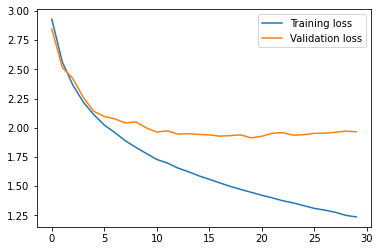

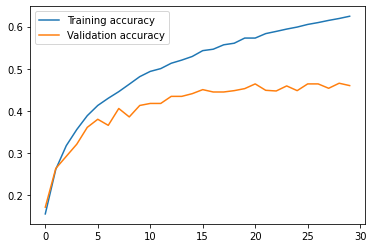

In [ ]:
# En vista de los experimentos seleccionamos como optimizador el el método Nadam
opt = tf.keras.optimizers.Nadam()
# Creamos el modelo 
model = BaseNet()
# Entrenamos y evaluamos el modelo 
score = fit_evaluate(model,opt,batch_size,epochs,v_xy_train_test,show=True,validation_split=0.1)

In [ ]:
print("Accuracy BaseNet: ", score[1])
print("Loss BaseNet:     ", score[0])

Accuracy BaseNet:  0.46880000829696655
Loss BaseNet:      1.9520515203475952


# Ejercicio 2: Mejora del modelo anterior

Creamos las funciones clave para el ejercicio.

In [7]:
def get_sets(v_xy_train_test):
  x_train = v_xy_train_test[0]
  y_train = v_xy_train_test[1]
  x_test  = v_xy_train_test[2]
  y_test  = v_xy_train_test[3]

  return x_train, y_train, x_test, y_test

def normalize( v_xy_train_test):
  
  # Obtenemos conjuntos de datos
  x_train, y_train, x_test, y_test = get_sets(v_xy_train_test)

  # Instanciamos el ImageDataGenerator con media 0 y desviacion estandar uno
  datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
  # Entrenamos al generador con el conjunto de datos de entrenamiento
  datagen.fit(x_train)
  # Normalizamos el conjunto de entrenamiento y el de test
  train_iterator = datagen.flow(x_train,y_train,batch_size=batch_size)
  test_iterator  = datagen.flow(x_test,y_test,batch_size=8)

  return train_iterator, test_iterator

###########################################################################################
###########################################################################################

def fit_au_datos(model, v_xy_train_test, batch_size, epochs, verbose = 0, show = False):
  """
    @brief:
      Función que realiza:
        1) Normalizado de datos de entrenamiento y test
        2) Aumentado de datos en el entrenamiento
        3) Entrenamiento del modelo
    @Return: 
      1) Modelo entrenado
      2) Iterador con los datos de test normalizados
      3) histórico 
  """
  # Cogemos datos de entrenamiento
  x_train_total = v_xy_train_test[0]
  y_train_total = v_xy_train_test[1]

  # Tomamos los datos de TEST (SOLO PARA NORMALIZARLOS)
  x_test = v_xy_train_test[2]
  y_test = v_xy_train_test[3]

  # Hacemos la particion de entrenamiento y validacion
  x_train, x_val, y_train, y_val = train_test_split(x_train_total , y_train_total , test_size=0.1)

  # Normalizamos VALIDACION con media 0 y desviación estandar 1
  datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

  # Aumentamos datos y normalizamos el entrenamiento
  datagen_au = ImageDataGenerator(
      featurewise_center=True,
      featurewise_std_normalization=True,
      zoom_range = 0.2,
      horizontal_flip=True)
      #rotation_range = 30)
  
  # Entrenamos con el conjunto de entrenamiento
  datagen.fit(x_train)
  datagen_au.fit(x_train)

  train_iterator = datagen_au.flow(x_train,y_train,batch_size=batch_size)
  val_iterator  = datagen.flow(x_val,y_val,batch_size=8)
  test_iterator = datagen.flow(x_test,y_test,batch_size=8)

  # Entrenamos al modelo
  hist = model.fit(
        train_iterator,
        steps_per_epoch=len(x_train)*0.9/batch_size,
        validation_data = val_iterator,
        batch_size = batch_size,
        validation_steps=len(x_train)*0.1/batch_size,
        epochs = epochs,
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)],
        verbose = verbose
  )

  # Visualizamos si queremos
  if show:
    mostrarEvolucion(hist)



  return model,test_iterator, hist


###########################################################################################
###########################################################################################

def cross_val(model,batch_size,epochs,v_train,show=False,verbose=0):
  """
    @brief: 
      Se realiza cross validation sobre el modelo 
    @Params:
      -) v_train: Datos de entrenamiento para CV --> [x_train, y_train]
    @Return:
      -) Devuelve la media del acurracy y loss function del CV
  """

  # Configuramos el modelo
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Nadam(),
                metrics=['accuracy'])

  # Totamos los datos de entrenamiento con su etiqueta
  x_train = v_train[0]
  y_train = v_train[1]

  
  weights       = model.get_weights()    # Guardamos los pesos    
  mean          = 0                      # Media de accuracy
  loss          = 0                      # Media de loss funtion
  
  # Inicializamos stratified-cross-validation
  skf = StratifiedKFold(n_splits = 5, shuffle = False) 
  
  # Para cada fold
  for train_index, test_index in skf.split(x_train,y_train.argmax(1)):

    # Calculo los conjuntos de entrenamiento y validacion
    X_train_cross, X_test_cross = x_train[train_index], x_train[test_index]
    Y_train_cross, Y_test_cross = y_train[train_index], y_train[test_index]

    # Entrenamos y evaluamos el modelo con los datos de entrenamiento y validación
    v_skf = [X_train_cross,Y_train_cross,X_test_cross,Y_test_cross]
    model, test_iterator ,historico = fit_au_datos(model,v_skf,batch_size,epochs,show=show,verbose=verbose)
    score = model.evaluate(test_iterator, verbose=verbose)
    
    # Acumulamos la accuracy y loss funtion
    mean = mean + score[1]
    loss = loss + score[0]

    # Reestablecemos los pesos para la siguiente partición
    model.set_weights(weights)

  # Hacemos la media (hemos usado 5 particiones)
  mean = mean/5
  loss = loss/5

  return [mean,loss]


###########################################################################################
###########################################################################################

def fit_evaluate( model,opt,batch_size,epochs,v_xy_train_test ,show=False,verbose=0):
  """
  @brief:
    Función que entrena al modelo y realiza una evaluación
  @Param:
    v_xy_train_test = [x_train,y_train,x_test,y_test]
  @Return:
    Score
  """

  # Configuramos el modelo
  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt,
                metrics=['accuracy'])
  
  # Entrenamos al modelo
  model,test_iterator, hist = fit_au_datos(model, v_xy_train_test, batch_size, epochs, verbose = verbose, show = True)
    
  # Evaluamos el modelo
  score = model.evaluate(test_iterator, verbose=verbose)

  return score


## Versión 1

Creamos los modelos

In [8]:
def BaseNet_v1_1():

  model = Sequential()

  model.add(Conv2D(filters=16,kernel_size=(3,3),input_shape=input_shape,name='Conv2D_11'))
  model.add(Conv2D(filters=16,kernel_size=(3,3),name='Conv2D_12'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_1'))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_1'))
  
  model.add(Conv2D(filters=32,kernel_size=(3,3),name='Conv2D_2'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_2'))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_2'))

  model.add(Flatten(name='Flatten'))

  model.add(Dropout(0.4, name='Dropout_1'))
  model.add(Dense(units=50,name='Dense_1'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_3'))
  
  model.add(Dropout(0.4, name='Dropout_2'))
  model.add(Dense(units=25,activation='softmax',name='Dense_2'))

  return model


#############################################################################################
#############################################################################################
#############################################################################################

def BaseNet_v1_2():

  model = Sequential()

  model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=input_shape,name='Conv2D_11'))
  model.add(Conv2D(filters=32,kernel_size=(3,3),name='Conv2D_12'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_1'))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_1'))
  
  model.add(Conv2D(filters=64,kernel_size=(3,3),name='Conv2D_2'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_2'))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_2'))

  model.add(Flatten(name='Flatten'))

  model.add(Dropout(0.4, name='Dropout_1'))
  model.add(Dense(units=25,activation='softmax',name='Dense_2'))

  return model

Experimentamos con el modelo haciendo con la técnica de validación cruzada.

In [9]:
# Version 1
model_1_1 = BaseNet_v1_1()
score = cross_val(model_1_1,batch_size,epochs,v_xy_train_test,show=False,verbose=0)
print("Loss: ", score[1])
print("Accuracy: ", score[0])

Loss:  1.7606566190719604
Accuracy:  0.4863199949264526


In [10]:
# Versión 2
model_1_2 = BaseNet_v1_2()
score = cross_val(model_1_2,batch_size,epochs,v_xy_train_test,show=False,verbose=0)
print("Loss: ", score[1])
print("Accuracy: ", score[0])

Loss:  1.6825984954833983
Accuracy:  0.5060800015926361


## Versión 2

Creamos los nuevos modelos

In [13]:
def BaseNet_v2():

  model = Sequential()

  canales = [32,64]
  for i in range(2): 
    model.add(Conv2D(filters=canales[i],kernel_size=(3,3),padding="same",input_shape=input_shape, name='Conv2D_{}'.format(i+1)))
    model.add(BatchNormalization())
    model.add(Activation(keras.activations.relu, name='Activation_{}'.format(i+1)))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_1'))

  model.add(UpSampling2D(interpolation='bilinear'))

  model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=(2,2), name='Conv2D_3'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_3'))

  canales = [128,256]
  for i in range(2): 
    model.add(Conv2D(filters=canales[i],kernel_size=(3,3),padding="same",name='Conv2D_{}'.format(i+4)))
    model.add(BatchNormalization())
    model.add(Activation(keras.activations.relu, name='Activation_{}'.format(i+4)))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_2'))

  model.add(Flatten(name='Flatten'))
  model.add(Dropout(0.4, name='Dropout_1'))
  model.add(Dense(units=25,activation='softmax',name='Classifier'))
 
  return model


#############################################################################################
#############################################################################################
#############################################################################################

def BaseNet_v2_2():

  model = Sequential()

  canales = [128,256]
  for i in range(2): 
    model.add(Conv2D(filters=canales[i],kernel_size=(3,3),padding="same",input_shape=input_shape, name='Conv2D_{}'.format(i+1)))
    model.add(BatchNormalization())
    model.add(Activation(keras.activations.relu, name='Activation_{}'.format(i+1)))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_1'))

  model.add(UpSampling2D(interpolation='bilinear'))

  model.add(Conv2D(filters=128,kernel_size=(3,3),padding="same",strides=(2,2), name='Conv2D_3'))
  model.add(BatchNormalization())
  model.add(Activation(keras.activations.relu, name='Activation_3'))

  canales = [256,512]
  for i in range(2): 
    model.add(Conv2D(filters=canales[i],kernel_size=(3,3),padding="same",name='Conv2D_{}'.format(i+4)))
    model.add(BatchNormalization())
    model.add(Activation(keras.activations.relu, name='Activation_{}'.format(i+4)))

  model.add(MaxPooling2D(pool_size=(2,2),name='MaxPooling_2'))

  model.add(Flatten(name='Flatten'))
  model.add(Dropout(0.4, name='Dropout_1'))
  model.add(Dense(units=25,activation='softmax',name='Classifier'))
 
  return model

Ejecutamos las distintas versiones

In [14]:
# Version 1
model2 = BaseNet_v2()
score = cross_val(model2,batch_size,epochs,v_xy_train_test,show=False,verbose=0)
print("Loss: ", score[0])
print("Accuracy: ", score[1])

Loss:  0.5168000161647797
Accuracy:  1.6215078592300416


In [15]:
# Version 2
model2_2 = BaseNet_v2_2()
score = cross_val(model2_2,batch_size,epochs,v_xy_train_test,show=False,verbose=0)
print("Loss: ", score[0])
print("Accuracy: ", score[1])

Loss:  0.5417599976062775
Accuracy:  1.553694748878479


Entrenamos la versión primera con todos los datos de entrenamiento y evaluamos con los datos de test para ver ver la capacidad de generalización que tiene el modelo. 

Epoch 1/30
158/158 [==============================] - 12s 60ms/step - loss: 3.3163 - accuracy: 0.2361 - val_loss: 2.3810 - val_accuracy: 0.3194
Epoch 2/30
158/158 [==============================] - 9s 59ms/step - loss: 2.1265 - accuracy: 0.3875 - val_loss: 2.1382 - val_accuracy: 0.3819
Epoch 3/30
158/158 [==============================] - 9s 59ms/step - loss: 1.8103 - accuracy: 0.4676 - val_loss: 1.6466 - val_accuracy: 0.4583
Epoch 4/30
158/158 [==============================] - 9s 58ms/step - loss: 1.5910 - accuracy: 0.5229 - val_loss: 1.6891 - val_accuracy: 0.5069
Epoch 5/30
158/158 [==============================] - 9s 59ms/step - loss: 1.4309 - accuracy: 0.5683 - val_loss: 1.8135 - val_accuracy: 0.5278
Epoch 6/30
158/158 [==============================] - 9s 59ms/step - loss: 1.2883 - accuracy: 0.6091 - val_loss: 1.5795 - val_accuracy: 0.5069
Epoch 7/30
158/158 [==============================] - 9s 59ms/step - loss: 1.2068 - accuracy: 0.6306 - val_loss: 1.4391 - val_accuracy: 0.590

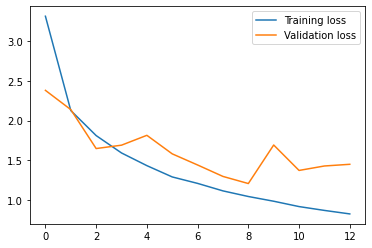

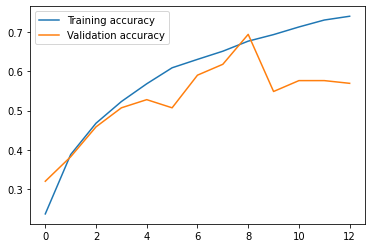

313/313 [==============================] - 2s 7ms/step - loss: 1.2104 - accuracy: 0.6236
Loss:  0.6236000061035156
Accuracy:  1.2103599309921265


In [21]:
opt = tf.keras.optimizers.Nadam()
final_model = BaseNet_v2()
score = fit_evaluate( final_model,opt,batch_size,epochs,v_xy_train_test ,show=True,verbose=1)
print("Loss: ", score[1])
print("Accuracy: ", score[0])


## Version 3

Creamos los modelos

In [19]:
def BaseNet_v3():

  input = keras.Input(shape=input_shape, name = 'Input')
  
  # Secuencial 
  x = Conv2D(filters=64,kernel_size=(3,3),padding="same",input_shape=input_shape, name='Conv2D_1')(input)
  x = BatchNormalization(name='BatchNorm_1')(x)
  x = Activation(keras.activations.relu, name='Relu_1')(x)
  
  x = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_2')(x)
  x = BatchNormalization(name='BatchNorm_2')(x)
  x = Activation(keras.activations.relu, name='Relu_2')(x)
  
  x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_1')(x) 
  
  # Primer boque de residuo 
  res1 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_3')(x)
  res1 = BatchNormalization()(res1)
  res1 = Activation(keras.activations.relu, name='Relu_3')(res1)
  # Fin primer bloque 

  suma1 = add([x, res1], name='Suma_bloque_1')

  # Segundo bloque de residuo
  res2 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_4')(suma1)
  res2 = BatchNormalization()(res2)
  res2 = Activation(keras.activations.relu, name='Relu_4')(res2)

  # Fin segundo bloque  

  suma2 = add([suma1, res2], name='Suma_bloque_2')

  x = MaxPooling2D(pool_size=(2,2),name='MaxPooling_2')(suma2)

  x = Conv2D(filters=256,kernel_size=(3,3), name='Conv2D_5')(x)
  x = BatchNormalization()(x)
  x = Activation(keras.activations.relu, name='Relu_5')(x)

  x = MaxPooling2D(pool_size=(2,2),name='MaxPooling_3')(x)

  x = (Flatten(name='Flatten'))(x)
  x = (Dropout(0.4, name='Dropout_1'))(x)
  output = (Dense(units=25,activation='softmax',name='Classifier'))(x)
  
  model = keras.Model(input, output, name="Version3")

  return model

#############################################################################################
#############################################################################################
#############################################################################################

def BaseNet_v3_2():

  input = keras.Input(shape=input_shape, name = 'Input')
  
  # Secuencial 
  x = Conv2D(filters=64,kernel_size=(3,3),padding="same",input_shape=input_shape, name='Conv2D_1')(input)
  x = BatchNormalization(name='BatchNorm_1')(x)
  x = Activation(keras.activations.relu, name='Relu_1')(x)
  
  x = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_2')(x)
  x = BatchNormalization(name='BatchNorm_2')(x)
  x = Activation(keras.activations.relu, name='Relu_2')(x)
  
  x = MaxPooling2D(pool_size=(2,2), name='MaxPooling_1')(x) 
  
  # Primer boque de residuo 
  res1 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_3')(x)
  res1 = BatchNormalization()(res1)
  res1 = Activation(keras.activations.relu, name='Relu_3')(res1)

  res1 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_31')(res1)
  res1 = BatchNormalization()(res1)

  # Fin primer bloque residual  

  suma1 = add([x, res1], name='Suma_bloque_1')
  suma1 = Activation(keras.activations.relu, name='Relu_31')(suma1)

  # Segundo bloque de residuo
  res2 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_4')(suma1)
  res2 = BatchNormalization()(res2)
  res2 = Activation(keras.activations.relu, name='Relu_4')(res2) 

  res2 = Conv2D(filters=128,kernel_size=(3,3),padding="same", name='Conv2D_41')(res2)
  res2 = BatchNormalization()(res2)
  # Fin segundo bloque residual

  suma2 = add([suma1, res2], name='Suma_bloque_2')
  suma2 = Activation(keras.activations.relu, name='Relu_41')(suma2) 

  x = MaxPooling2D(pool_size=(2,2),name='MaxPooling_2')(suma2)

  x = Conv2D(filters=128,kernel_size=(3,3), name='Conv2D_5')(x)
  x = BatchNormalization()(x)
  x = Activation(keras.activations.relu, name='Relu_5')(x)

  x = MaxPooling2D(pool_size=(2,2),name='MaxPooling_3')(x)

  x = (Flatten(name='Flatten'))(x)
  x = (Dropout(0.4, name='Dropout_1'))(x)
  output = (Dense(units=25,activation='softmax',name='Classifier'))(x)
  
  model = keras.Model(input, output, name="Version3")

  return model

Ejecutamos los modelos

In [ ]:
# Versión 1
model3 = BaseNet_v3()
score = cross_val(model3,batch_size,epochs,v_xy_train_test,show=False,verbose=1)
print("Loss: ", score[1])
print("Accuracy: ", score[0])

Epoch 1/30
126/126 [==============================] - 11s 67ms/step - loss: 2.8008 - accuracy: 0.2504 - val_loss: 2.7016 - val_accuracy: 0.2333
Epoch 2/30
126/126 [==============================] - 8s 64ms/step - loss: 2.1975 - accuracy: 0.3757 - val_loss: 2.1761 - val_accuracy: 0.3583
Epoch 3/30
126/126 [==============================] - 8s 64ms/step - loss: 1.8700 - accuracy: 0.4559 - val_loss: 1.8040 - val_accuracy: 0.4250
Epoch 4/30
126/126 [==============================] - 8s 63ms/step - loss: 1.6665 - accuracy: 0.5065 - val_loss: 1.9211 - val_accuracy: 0.4583
Epoch 5/30
126/126 [==============================] - 8s 63ms/step - loss: 1.4990 - accuracy: 0.5427 - val_loss: 1.2874 - val_accuracy: 0.6083
Epoch 6/30
126/126 [==============================] - 8s 63ms/step - loss: 1.3724 - accuracy: 0.5846 - val_loss: 1.3697 - val_accuracy: 0.6167
Epoch 7/30
126/126 [==============================] - 8s 63ms/step - loss: 1.2673 - accuracy: 0.6190 - val_loss: 1.5738 - val_accuracy: 0.541

In [ ]:
# Versión 2
model3_2 = BaseNet_v3_2()
score = cross_val(model3_2,batch_size,epochs,v_xy_train_test,show=False,verbose=1)
print("Loss: ", score[0])
print("Accuracy: ", score[1])

Epoch 1/30
126/126 [==============================] - 13s 75ms/step - loss: 2.8598 - accuracy: 0.2282 - val_loss: 2.7150 - val_accuracy: 0.2417
Epoch 2/30
126/126 [==============================] - 9s 69ms/step - loss: 2.2595 - accuracy: 0.3535 - val_loss: 2.0780 - val_accuracy: 0.3750
Epoch 3/30
126/126 [==============================] - 9s 70ms/step - loss: 1.9806 - accuracy: 0.4170 - val_loss: 2.2721 - val_accuracy: 0.3833
Epoch 4/30
126/126 [==============================] - 9s 70ms/step - loss: 1.7490 - accuracy: 0.4752 - val_loss: 1.9356 - val_accuracy: 0.4333
Epoch 5/30
126/126 [==============================] - 9s 70ms/step - loss: 1.5792 - accuracy: 0.5196 - val_loss: 1.5784 - val_accuracy: 0.5500
Epoch 6/30
126/126 [==============================] - 9s 68ms/step - loss: 1.4456 - accuracy: 0.5635 - val_loss: 1.6202 - val_accuracy: 0.5417
Epoch 7/30
126/126 [==============================] - 9s 68ms/step - loss: 1.3211 - accuracy: 0.5932 - val_loss: 1.5681 - val_accuracy: 0.533

Entrenamos la segunda versión con todos los datos de entrenamiento (dejando 10% para validación) y evaluamos en el conjunto de test para ver como generaliza este modelo. 

Epoch 1/30
158/158 [==============================] - 13s 65ms/step - loss: 2.9666 - accuracy: 0.2223 - val_loss: 2.5173 - val_accuracy: 0.2847
Epoch 2/30
158/158 [==============================] - 10s 64ms/step - loss: 2.2038 - accuracy: 0.3637 - val_loss: 1.9541 - val_accuracy: 0.4514
Epoch 3/30
158/158 [==============================] - 10s 64ms/step - loss: 1.9676 - accuracy: 0.4197 - val_loss: 1.7160 - val_accuracy: 0.4792
Epoch 4/30
158/158 [==============================] - 10s 64ms/step - loss: 1.7911 - accuracy: 0.4690 - val_loss: 1.4978 - val_accuracy: 0.5556
Epoch 5/30
158/158 [==============================] - 11s 70ms/step - loss: 1.6048 - accuracy: 0.5153 - val_loss: 1.5787 - val_accuracy: 0.4861
Epoch 6/30
158/158 [==============================] - 10s 64ms/step - loss: 1.4696 - accuracy: 0.5547 - val_loss: 1.5720 - val_accuracy: 0.5694
Epoch 7/30
158/158 [==============================] - 10s 64ms/step - loss: 1.3719 - accuracy: 0.5807 - val_loss: 1.4133 - val_accuracy:

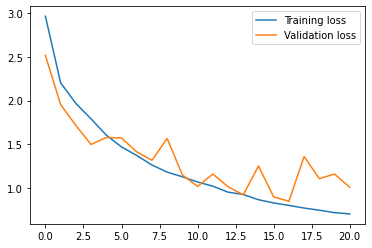

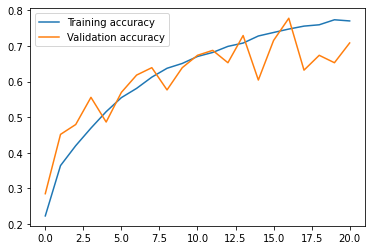

313/313 [==============================] - 3s 9ms/step - loss: 0.9806 - accuracy: 0.7064
Loss:  0.9805776476860046
Accuracy:  0.7063999772071838


In [22]:
final_model_bonus = BaseNet_v3_2()
score = fit_evaluate(final_model_bonus ,opt,batch_size,epochs,v_xy_train_test ,show=True,verbose=1)
print("Loss: ", score[0])
print("Accuracy: ", score[1])